<a href="https://colab.research.google.com/github/shreyassathyamangalam/colab_notebooks/blob/main/flood_prediction_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries ##

In [ ]:
# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import tensorflow_addons as tfa
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Lambda, Concatenate, Add, BatchNormalization, LeakyReLU, ELU
from keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping


# holy grail
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# sklearn
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn import preprocessing
from sklearn.metrics import classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer


# others
import math
import os
import time
from scipy.stats import entropy
from scipy.signal import welch, find_peaks

## Load Data ##

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pwd

/content


In [ ]:
!ls

drive  sample_data


In [ ]:
!ls drive/MyDrive/

'Colab Notebooks'   test.csv   train.csv


In [ ]:
df_train = pd.read_csv("drive/MyDrive/train.csv")
df_test = pd.read_csv("drive/MyDrive/test.csv")

In [ ]:
df_train.head()

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,0,5,8,5,8,6,4,4,3,3,4,2,5,3,3,5,4,7,5,7,3,0.445
1,1,6,7,4,4,8,8,3,5,4,6,9,7,2,0,3,5,3,3,4,3,0.450
2,2,6,5,6,7,3,7,1,5,4,5,6,7,3,7,5,6,8,2,3,3,0.530
3,3,3,4,6,5,4,8,4,7,6,8,5,2,4,7,4,4,6,5,7,5,0.535
4,4,5,3,2,6,4,4,3,3,3,3,5,2,2,6,6,4,1,2,3,5,0.415


## Exploratory Data Analysis ##

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


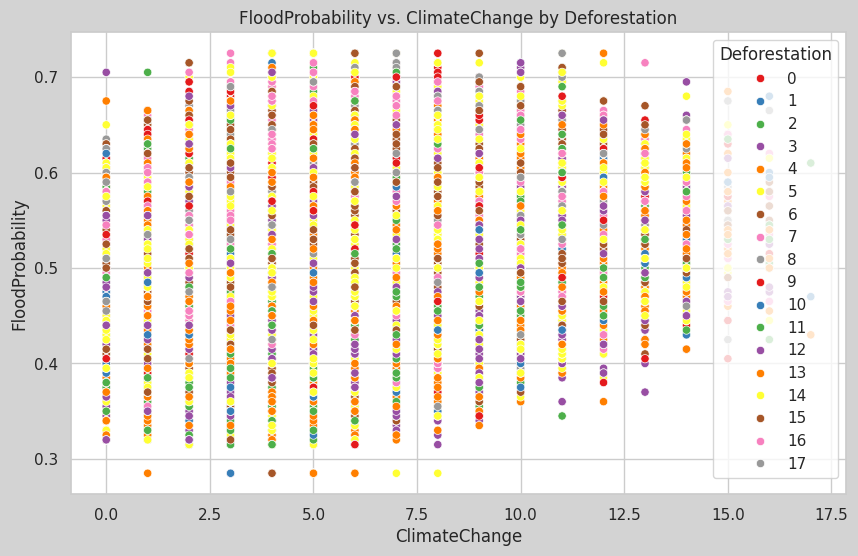

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_train, x='ClimateChange', y='FloodProbability', hue='Deforestation',
                palette='Set1')
plt.title('FloodProbability vs. ClimateChange by Deforestation')
plt.xlabel('ClimateChange')
plt.ylabel('FloodProbability')
plt.legend(title='Deforestation')
plt.gcf().set_facecolor('lightgrey')
plt.show()

In [ ]:
numeric_features = df_train.select_dtypes(include=['int64', 'float64']).columns.drop('id')

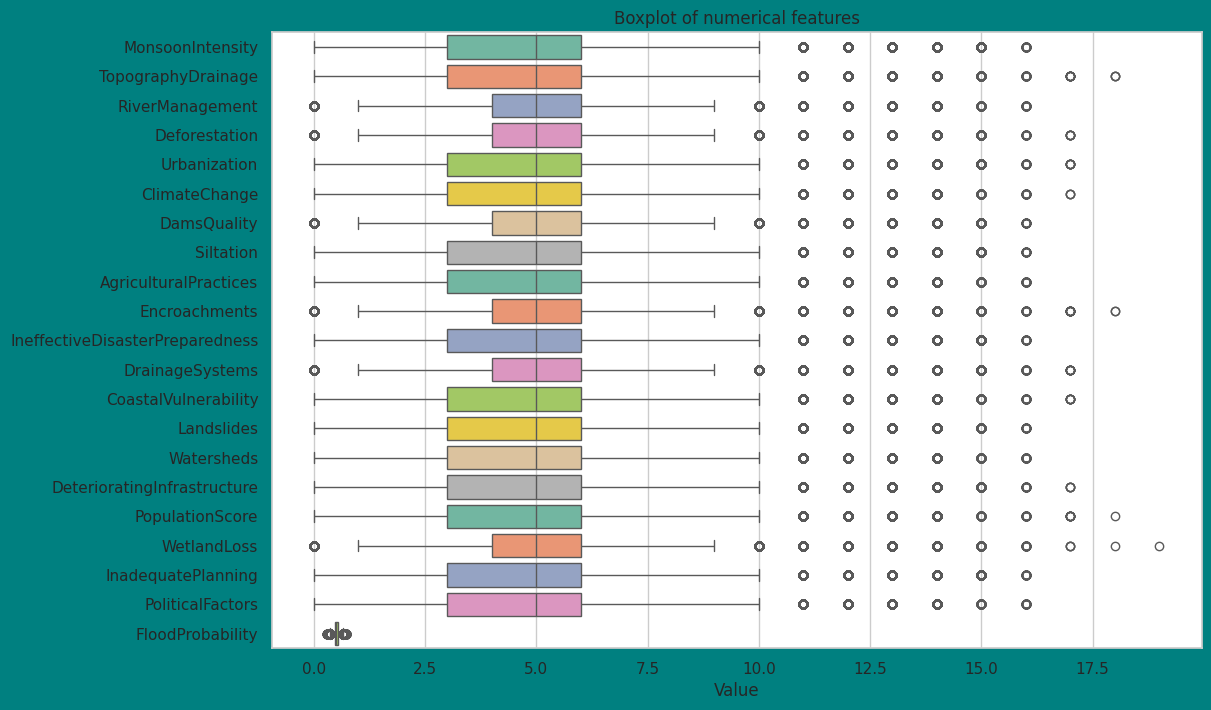

In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_train[numeric_features], orient='h', palette='Set2')
plt.title("Boxplot of numerical features")
plt.xlabel('Value')
plt.gcf().set_facecolor('#008080')
plt.show()

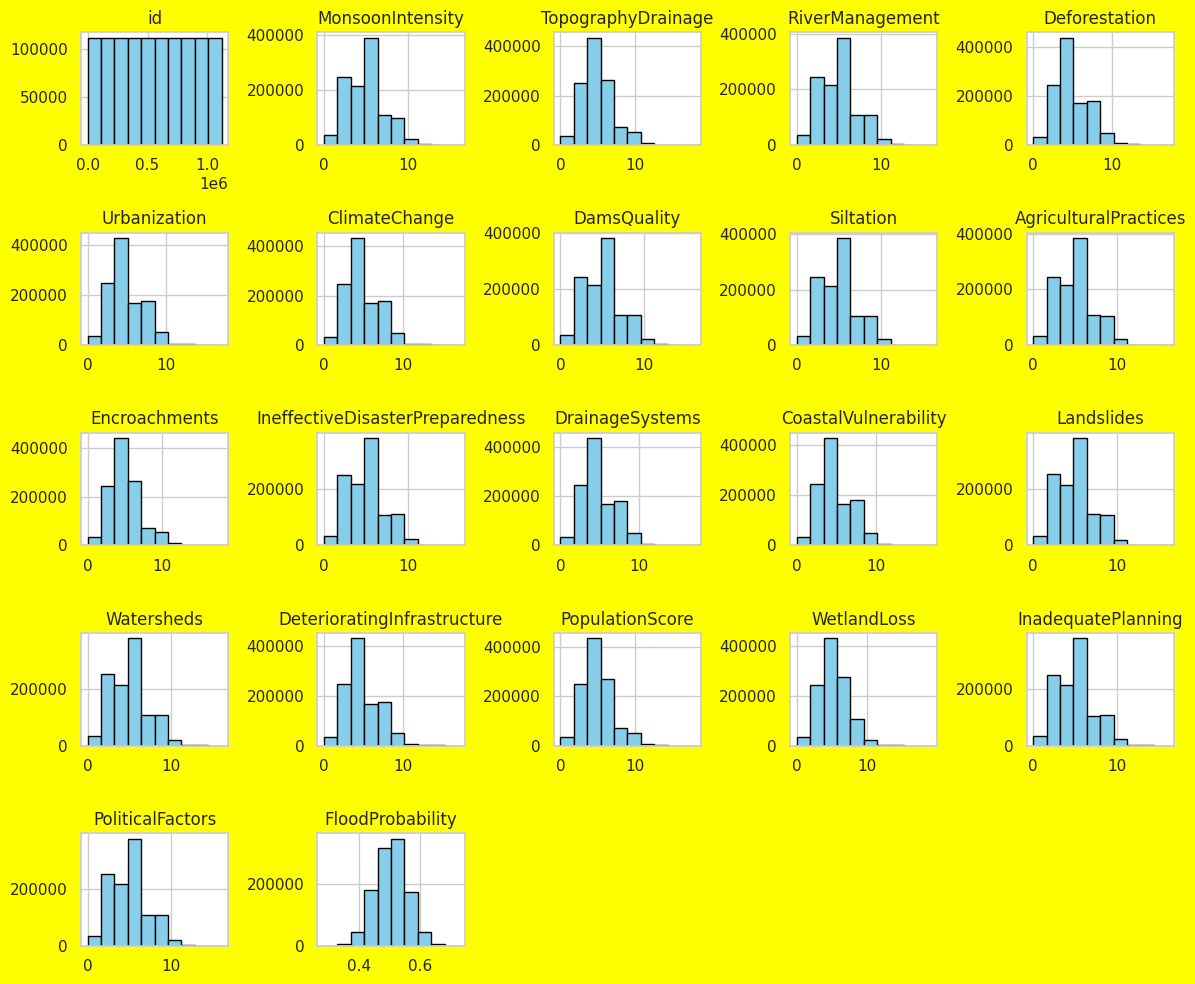

In [ ]:
df_train.hist(figsize=(12, 10), color='skyblue', edgecolor='black')
plt.gcf().set_facecolor('yellow')
plt.tight_layout()
plt.show()

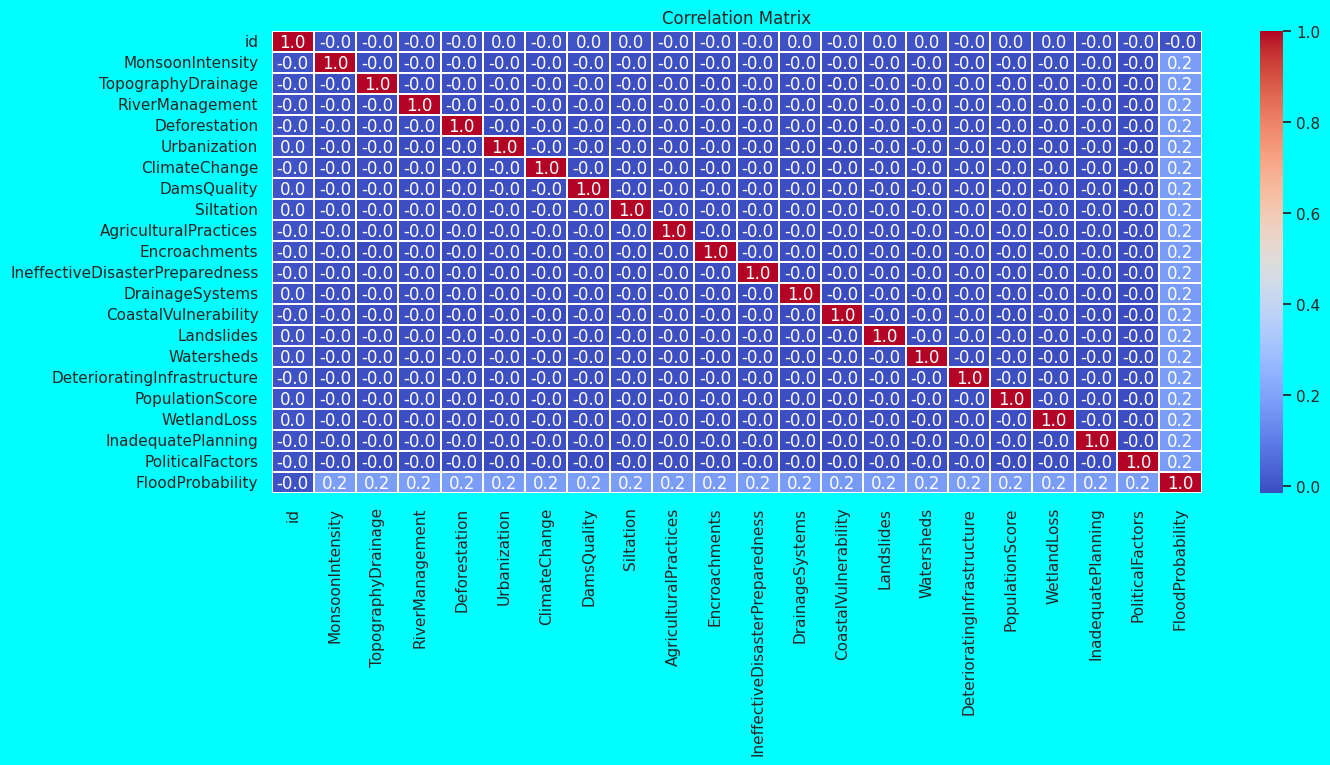

In [ ]:
correlation_matrix = df_train.corr()
plt.figure(figsize=(15, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".1f", linewidths=0.2)
plt.gcf().set_facecolor('#00FFFF')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
df_train.drop(columns=['id'], axis=1, inplace=True)
df_test.drop(columns=['id'], axis=1, inplace=True)

In [ ]:
df_train.columns

Index(['MonsoonIntensity', 'TopographyDrainage', 'RiverManagement',
       'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality',
       'Siltation', 'AgriculturalPractices', 'Encroachments',
       'IneffectiveDisasterPreparedness', 'DrainageSystems',
       'CoastalVulnerability', 'Landslides', 'Watersheds',
       'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss',
       'InadequatePlanning', 'PoliticalFactors', 'FloodProbability'],
      dtype='object')

In [ ]:
y = df_train['FloodProbability']
df_train = df_train.drop(columns=['FloodProbability'], axis=1)

In [ ]:
def count_peaks(row):
    peaks, _ = find_peaks(row)
    return len(peaks)

def spectral_entropy(row):
    _, psd = welch(row)
    return entropy(psd)

def cleaning(dataset):

    features = dataset.columns.tolist()
    dataset['mean_features'] = 0.1 * dataset[features].mean(axis=1)
    dataset['std_features'] = dataset[features].std(axis=1)
    dataset['max_features'] = dataset[features].max(axis=1)
    dataset['min_features'] = dataset[features].min(axis=1)
    dataset['range_features'] = dataset['max_features'] - dataset['min_features']
    dataset['variance_features'] = dataset[features].var(axis=1)
    dataset['skewness_features'] = dataset[features].skew(axis=1)
    dataset['sum_features'] = dataset[features].sum(axis=1)


    mean_abs_dev = (dataset[features] - dataset[features].mean(axis=1).values.reshape(-1, 1)).abs().mean(axis=1)
    median_abs_dev = (dataset[features] - dataset[features].median(axis=1).values.reshape(-1, 1)).abs().mean(axis=1)
    range_abs_diff = (dataset[features] - dataset[features].median(axis=1).values.reshape(-1, 1)).abs().max(axis=1) - (dataset[features] - dataset[features].median(axis=1).values.reshape(-1, 1)).abs().min(axis=1)
    geometric_mean = np.exp(np.log(dataset[features].replace(0, 1)).mean(axis=1))
    harmonic_mean = len(features) / (1 / dataset[features].replace(0, 1)).sum(axis=1)
    coeff_variation = dataset['std_features'] / dataset['mean_features']


    quartiles = dataset[features].quantile([0.25, 0.5, 0.75], axis=1)
    dataset['first_quartile'] = quartiles.loc[0.25]
    dataset['second_quartile'] = quartiles.loc[0.5]
    dataset['third_quartile'] = quartiles.loc[0.75]


    kurtosis_features = dataset[features].kurtosis(axis=1)
    dataset['kurtosis_features'] = kurtosis_features

    dataset['mean_absolute_deviation'] = mean_abs_dev
    dataset['median_absolute_deviation'] = median_abs_dev
    dataset['range_abs_diff'] = range_abs_diff
    dataset['geometric_mean'] = geometric_mean
    dataset['harmonic_mean'] = harmonic_mean
    dataset['coeff_variation'] = coeff_variation

    peak_features = dataset[features].apply(count_peaks, axis=1)
    dataset['peak_frequency'] = peak_features

    spectral_entropy_features = dataset[features].apply(spectral_entropy, axis=1)
    dataset['spectral_entropy'] = spectral_entropy_features


    entropy_features = dataset[features].apply(entropy, axis=1)
    dataset['entropy'] = entropy_features

    dataset.drop(features, axis=1, inplace=True)

    return dataset

In [ ]:
df_train = cleaning(df_train)
df_test = cleaning(df_test)

/usr/local/lib/python3.10/dist-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 20, using nperseg = 20
  warnings.warn('nperseg = {0:d} is greater than input length '
/usr/local/lib/python3.10/dist-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 20, using nperseg = 20
  warnings.warn('nperseg = {0:d} is greater than input length '


In [ ]:
scaler = StandardScaler()
scaled_train_data = scaler.fit_transform(df_train)
scaled_test_data = scaler.transform(df_test)

## split data into train and test datasets ##

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(scaled_train_data, y,
                                                    test_size=0.2, random_state = 42)

## Simple Neural Network Model ##

In [ ]:
def create_improved_model(input_shape):
  model = Sequential()
  model.add(Dense(256, activation='relu', input_shape=input_shape))
  model.add(Dropout(rate=0.2))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(rate=0.1))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(1))

  model.compile(optimizer='adam', loss='mse')
  return model

In [ ]:
input_shape = (X_train.shape[1], )
improved_model = create_improved_model(input_shape)

In [ ]:
model_checkpoint = ModelCheckpoint(
    filepath = "best_model.h5",
    monitor = "val_loss",
    verbose = 1,
    save_best_only = True
)

In [ ]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=1,
    mode="auto"
)

In [ ]:
history = improved_model.fit(
    X_train, y_train,
    validation_data = (X_test, y_test),
    epochs = 1000,
    batch_size = 32,
    verbose = 1,
    callbacks = [model_checkpoint, early_stopping]
)

Epoch 1/1000
27949/27949 [==============================] - ETA: 0s - loss: 6.2308e-04
Epoch 1: val_loss improved from inf to 0.00038, saving model to best_model.h5
27949/27949 [==============================] - 193s 7ms/step - loss: 6.2308e-04 - val_loss: 3.8036e-04
Epoch 2/1000
    9/27949 [..............................] - ETA: 3:23 - loss: 3.7773e-04

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27947/27949 [============================>.] - ETA: 0s - loss: 3.9192e-04
Epoch 2: val_loss improved from 0.00038 to 0.00038, saving model to best_model.h5
27949/27949 [==============================] - 126s 5ms/step - loss: 3.9193e-04 - val_loss: 3.8011e-04
Epoch 3/1000
27944/27949 [============================>.] - ETA: 0s - loss: 3.8692e-04
Epoch 3: val_loss improved from 0.00038 to 0.00037, saving model to best_model.h5
27949/27949 [==============================] - 116s 4ms/step - loss: 3.8692e-04 - val_loss: 3.6591e-04
Epoch 4/1000
27944/27949 [============================>.] - ETA: 0s - loss: 3.8347e-04
Epoch 4: val_loss did not improve from 0.00037
27949/27949 [==============================] - 114s 4ms/step - loss: 3.8350e-04 - val_loss: 3.7256e-04
Epoch 5/1000
27943/27949 [============================>.] - ETA: 0s - loss: 3.7973e-04
Epoch 5: val_loss did not improve from 0.00037
27949/27949 [==============================] - 123s 4ms/step - loss: 3.7973e-04 - val_loss: 3.9403